In [1]:
# Packages
import generate_3_D_tensor as gdata
import numpy as np
import msc_multiple as msc_multiple
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import DBSCAN
import itertools
import fonctions as f
import multiple_dbscan as multiple_dbscan
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
sigma = 80
m = 50 # the dimension of each mode
k = 2  # the number of cluster in each mode

# -----------------------
mse_MSC , mse_Extension, number_cluster = [], [], []
for test in range(20):
    # generate data
    D = gdata.Data_generator(m,m,m,k1=10,k2=10,k3=10, cluster=k, sigma=sigma) 
    data1 = D.multiple_cluster()
    # -------------Set the value of epsilon-------
    e_ = 0.001
    res = msc_multiple.Msc(data1, e_ = e_)
    
    msc_output = res.get_result_triclustering()
    
    sim_matrices = res.get_cij()
    # separation of indices
    output_dbscan = []
    for h in range(3): # the cluster in the three mode
        # recover the similarity matrix
        data = sim_matrices[h].T
        data = data[msc_output[h][0],:]
        epsilon = (len(data[:,0])*e_ / 2 + np.sqrt(np.log(m - len(data[:,0]))))**0.5
        clustering = DBSCAN(eps=epsilon, min_samples=2).fit(np.abs(data))
        cluster = clustering.labels_
        cluster_uniq = np.unique(cluster)
        number_cluster.append(len(cluster_uniq))
        
        indices = []
        for i in cluster_uniq:
            intermediate = [msc_output[h][0][g] for g, j in enumerate(cluster) if j == i]
            indices.append(intermediate)
        output_dbscan.append(indices)
        
    # MSC
    mse_MSC.append(f.rmse(data1, msc_output[0][0], msc_output[1][0], msc_output[2][0]) )
    # MSC-Extension
    mse_E = []
    for j in itertools.product(output_dbscan[0], output_dbscan[1], output_dbscan[2]):
        mse_E.append(f.rmse(data1, j[0], j[1], j[2]))
    mse_Extension.append(np.mean(mse_E))

In [5]:
print("MSC : mean = ", np.mean(mse_MSC), " and std = ", np.std(mse_MSC))
print("MSC-extension : mean = ", np.mean(mse_Extension), " and std = ", np.std(mse_Extension))
print("Number of cluster in each mode with MSC-Extension : ", np.unique(number_cluster))

MSC : mean =  120.19567833406484  and std =  11.281216837498388
MSC-extension : mean =  28.40480152637726  and std =  2.9008088369584546
Number of cluster in each mode with MSC-Extension :  [2]


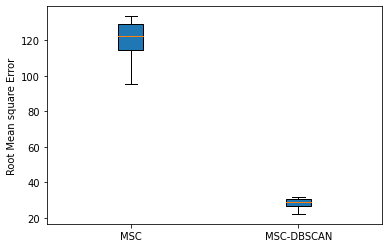

In [6]:
mse = [mse_MSC, mse_Extension]
plt.boxplot(mse,patch_artist=True,labels=['MSC','MSC-DBSCAN'])
plt.ylabel("Root Mean square Error")
#plt.savefig('./image/msc_and_extension.png')
plt.show()

In [7]:
#------Adjusted Rand Index------------------
sigma = 80
m = 50 # the dimension of each mode
k = 2  # the number of cluster in each mode
# -------Real clusters----------------
real = [0 for i in range(10)] + [1 for i in range(10)] + [2 for _ in range(m-20)]
# -----------------------
ARI_mean, ARI_std = [], []
for sigma in range(50,101,5):
    ari = []
    for _ in range(10):
        # generate data
        D = gdata.Data_generator(m,m,m,k1=10,k2=10,k3=10, cluster=k, sigma=sigma) 
        data1 = D.multiple_cluster()
        # -------------Set the value of epsilon-------
        e_ = 0.001
        res = msc_multiple.Msc(data1, e_ = e_)
    
        msc_output = res.get_result_triclustering()
        sim_matrices = res.get_cij()
        # MSC-Extension
        indices = []
        for j in range(3):
            intermediate = []
            for i in range(len(msc_output[0])):
                intermediate = intermediate  + msc_output[j][i] 
            indices.append(list(set(intermediate)))
        
        dim = (m,m,m)  # data1.shape
        MscExtension = multiple_dbscan.Msc_extension(dim, sim_matrices, indices, e_, minP=2)
        cluster = MscExtension._result[0].tolist()
        cluster = cluster + [2 for _ in range(m-len(cluster))]
        ari.append(adjusted_rand_score(real, cluster))
    ARI_mean.append( np.mean(ari)  )
    ARI_std.append( np.std(ari) )

In [ ]:
print( ARI_mean, " and ",  ARI_std )
x = [i for i in range(50,101,5)]
plt.errorbar(x, ARI_mean, ARI_std, linestyle='None', marker='')
plt.plot(x, ARI_mean, label="ARI")
plt.xlabel("gamma")
plt.ylabel("ARI")
plt.legend(loc="lower right")
plt.savefig('./image/ARI_Extension.png')
plt.show()

# REAL DATA

In [3]:
# Packages
from scipy.io import loadmat
import numpy as np
from numpy import linalg as la
import random
# -----------------------------
annots = loadmat('../../data/Flow_Injection/fia.mat')
print("the keys :" , annots.keys() )

d = annots['X']
print("X dimension :", annots["DimX"])

data = np.reshape(d, (12,100,89), order="F")
print("data dimension :", data.shape)

the keys : dict_keys(['__header__', '__version__', '__globals__', 'ans', 'X', 'DimX', 'y', 'Xs', 'ys', 'TimeAxis', 'Wavelength'])
X dimension : [[ 12 100  89]]
data dimension : (12, 100, 89)


In [5]:
# Evaluation for several repetition 
# Iterative MSC and MSC-Extension
data1 = data

e_ = 0.00013
res = msc_multiple.Msc(data1, e_ = e_)
  
msc_output = res.get_result_triclustering()
sim_matrices = res.get_cij()
    
# MSC-Extension
index = []
for j in range(3):
    intermediate = []
    for i in range(len(msc_output[0])):
        intermediate = intermediate  + msc_output[j][i] 
    index.append(list(set(intermediate)))
        
dim = data1.shape
MscExtension = multiple_dbscan.Msc_extension(dim, sim_matrices, index, e_, minP=2)

# -----The clusters------
print("MSC cluster :", msc_output)
print("MSC_Extension :", MscExtension._result)

MSC cluster : [[[6, 10, 11]], [[0, 1, 2, 3, 4, 5, 6, 7, 8]], [[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]]
MSC_Extension : [array([0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


In [24]:
mse_MSC , mse_Extension = [], []

# Mean Square Error
mse_msc = []
for j in itertools.product(msc_output[0], msc_output[1], msc_output[2]):
    mse_msc.append(f.rmse(data1, j[0], j[1], j[2]))

mse_dbscan = []
for j in itertools.product(MscExtension._cluster_real_index[0], MscExtension._cluster_real_index[1], MscExtension._cluster_real_index[2]):
    mse_dbscan.append(f.rmse(data1, j[0], j[1], j[2]))
    
mse_MSC.append(np.mean(mse_msc)**0.5)
mse_Extension.append(np.mean(mse_dbscan)**0.5)
    
# ---- RMSE -----------
print("RMSE MSC : ", mse_MSC, )
print("RMSE MSC-extension : ", mse_Extension)

RMSE MSC :  [4.923709752827713]
RMSE MSC-extension :  [4.923709752827713]
